In [51]:
import nbformat as nbf

# Read the notebook file
with open('02. ARIMA Time Series Forecasting_120mth.ipynb', 'r', encoding='utf-8') as f:
    notebook_content = f.read()

# Convert the notebook content to a notebook node object
notebook_node = nbf.reads(notebook_content, as_version=nbf.NO_CONVERT)

# Convert the notebook to a Python script
python_script, _ = exporter.from_notebook_node(notebook_node)

# Save the Python script to a file
with open('02. ARIMA Time Series Forecasting_120mth.py', 'w', encoding='utf-8') as f:
    f.write(python_script)


# ARIMA Time Series Forecasting

ARIMA model assumption - stationary: the time series has its statistical properties remain constant across time

ARIMA models combine three distinct components:
1. Autoregression, represented as AR
2. Differencing, represented as I
3. Moving average, represented as MA

Three components/parameters: AR + I + MA (p, d, q)
1. p (Autoregression Order): The number of lag observations included in the model.
2. d (Differencing Order): The number of times the data have had past values subtracted (to make the data stationary).
3. q (Moving Average Order): The size of the moving average window.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.plotting import autocorrelation_plot

## Step 1: Load and Preprocess the Dataset

In [26]:
Canadian_data=pd.read_csv('Canadian Sales.csv')

Canadian_data.reset_index(inplace=True)
Canadian_data = Canadian_data[['REF_DATE', 'VALUE']]

Canadian_data['REF_DATE'] = pd.to_datetime(Canadian_data['REF_DATE'])

print(Canadian_data.dtypes)
Canadian_data.head()

REF_DATE    datetime64[ns]
VALUE              float64
dtype: object


,REF_DATE,VALUE
0,1946-10-01,11462.0
1,1946-11-01,13497.0
2,1946-12-01,12689.0
3,1947-01-01,13977.0
4,1947-02-01,15806.0


In [27]:
# display last 12 rows
Canadian_data.tail(12)

,REF_DATE,VALUE
2100,2023-03-01,8483490.0
2101,2023-04-01,8252891.0
2102,2023-05-01,9648708.0
2103,2023-06-01,9352513.0
2104,2023-07-01,8190694.0
2105,2023-08-01,8926326.0
2106,2023-09-01,9154748.0
2107,2023-10-01,8400811.0
2108,2023-11-01,8071438.0
2109,2023-12-01,7455783.0


In [28]:
Canadian_data=Canadian_data.tail(120)

In [29]:
# Check for missing values
print(Canadian_data.isnull().sum())

REF_DATE    0
VALUE       0
dtype: int64


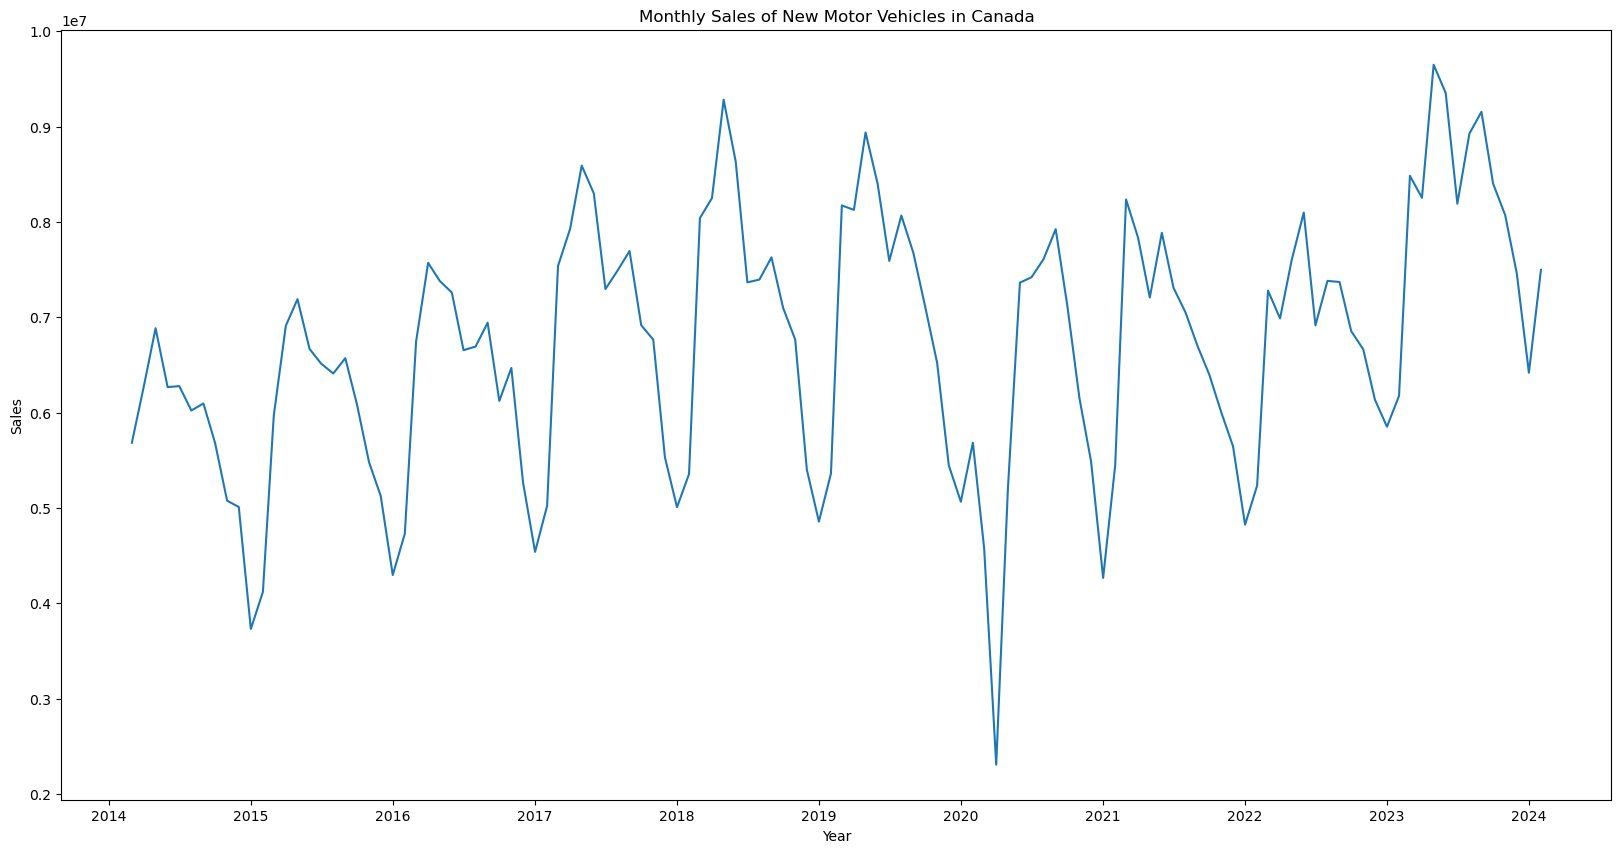

In [30]:
# Adjust figure size
plt.figure(figsize=(20, 10))

# Plot the lineplot
sns.lineplot(data=Canadian_data, x='REF_DATE', y='VALUE')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Monthly Sales of New Motor Vehicles in Canada')
plt.show()

## Step 2: Check for Stationarity

In [31]:
# Function to perform the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Applying the Dickey-Fuller test on the 'VALUE' column
test_stationarity(Canadian_data['VALUE'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.702879
p-value                          0.846002
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


If the p-value is less than 0.05 and the test statistic is less than the critical values, we can conclude the series is stationary.

But it is not, we'll consider applying transformations to make it stationary.

## Step 3: Data Transformation

In [32]:
# First differencing
# Canadian_data['VALUE_diff'] = Canadian_data['VALUE'].diff()

Canadian_data['Sales_First_Difference'] = Canadian_data['VALUE'] - Canadian_data['VALUE'].shift(1)
Canadian_data['Seasonal_First_Difference']=Canadian_data['VALUE']-Canadian_data['VALUE'].shift(12)
Canadian_data.dropna().head()

,REF_DATE,VALUE,Sales_First_Difference,Seasonal_First_Difference
2004,2015-03-01,5967542.0,1849400.0,284693.0
2005,2015-04-01,6910768.0,943226.0,631876.0
2006,2015-05-01,7189418.0,278650.0,304456.0
2007,2015-06-01,6667610.0,-521808.0,400759.0
2008,2015-07-01,6512342.0,-155268.0,235224.0


In [33]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")


# Again testing if data is stationary
adfuller_test(Canadian_data['Sales_First_Difference'].dropna())

ADF Test Statistic : -3.3841485996921383
p-value : 0.011511261047113136
#Lags Used : 13
Number of Observations : 105
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Axes: >

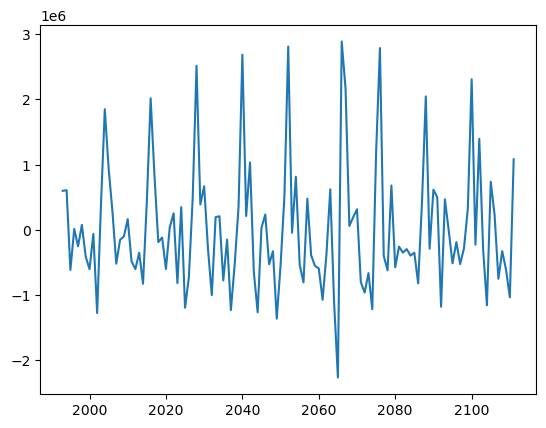

In [34]:
Canadian_data['Sales_First_Difference'].plot()

## Step 4: Identify and Remove Outliers

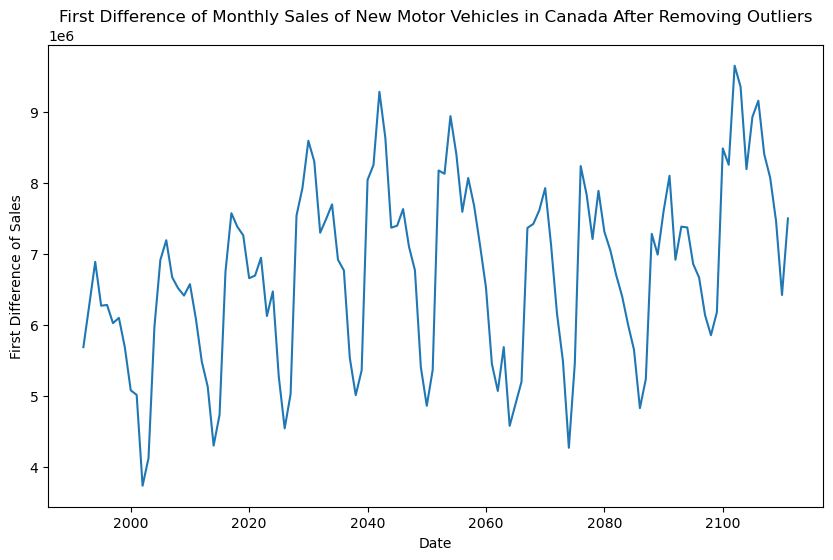

In [35]:
# Calculate IQR
Q1 = Canadian_data['VALUE'].quantile(0.25)
Q3 = Canadian_data['VALUE'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
filtered_data = Canadian_data[(Canadian_data['VALUE'] >= lower_bound) & (Canadian_data['VALUE'] <= upper_bound)]

# Plot to see data after removing outliers
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['VALUE'])
plt.title('First Difference of Monthly Sales of New Motor Vehicles in Canada After Removing Outliers')
plt.xlabel('Date')
plt.ylabel('First Difference of Sales')
plt.show()

## Step 5: Split the Data into Training and Test Sets

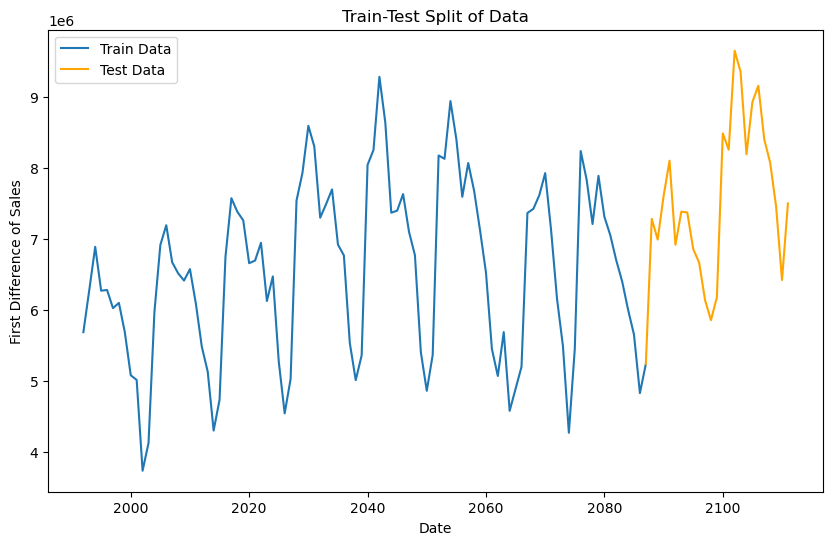

In [36]:
# Calculate the split point
split_point = int(len(filtered_data) * 0.8)

# Split into training and test sets
train_data = filtered_data[:split_point]
test_data = filtered_data[split_point-1:]

# Plot both to visually inspect the split
plt.figure(figsize=(10, 6))
plt.plot(train_data['VALUE'], label='Train Data')
plt.plot(test_data['VALUE'], label='Test Data', color='orange')
plt.title('Train-Test Split of Data')
plt.xlabel('Date')
plt.ylabel('First Difference of Sales')
plt.legend()
plt.show()

## Step 6: Model Identification

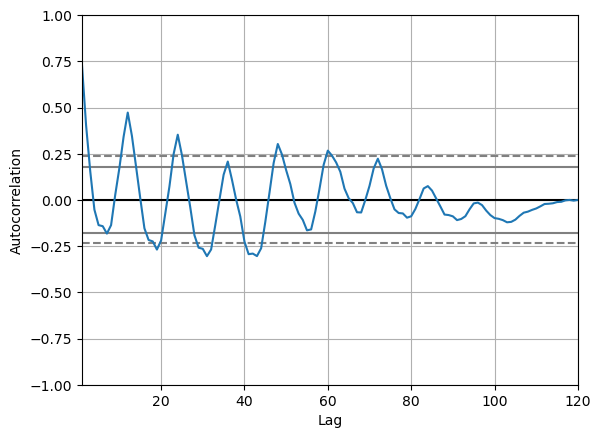

In [37]:
autocorrelation_plot(Canadian_data['VALUE'])
plt.show()

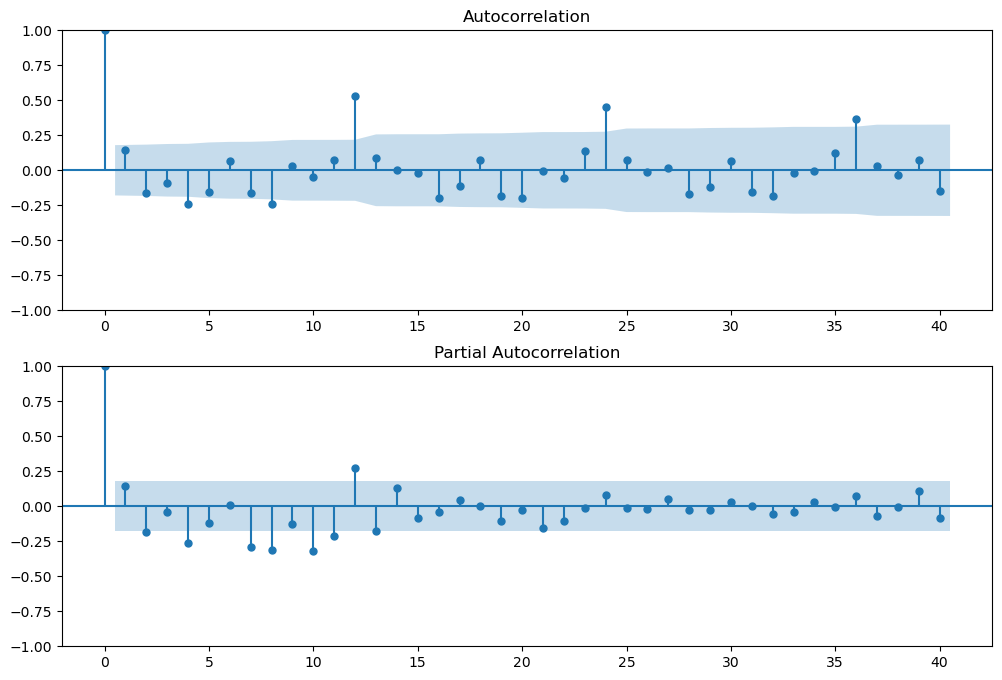

In [38]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Canadian_data['Sales_First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Canadian_data['Sales_First_Difference'].dropna(),lags=40,ax=ax2)

## Step 7: Model Fitting

In [39]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(Canadian_data['VALUE'], order=(12, 2, 1))
model_fit = model.fit()
model_fit.summary()

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALUE   No. Observations:                  120
Model:                ARIMA(12, 2, 1)   Log Likelihood               -1761.771
Date:                Tue, 23 Apr 2024   AIC                           3551.542
Time:                        12:35:14   BIC                           3590.331
Sample:                             0   HQIC                          3567.291
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0397      0.095      0.416      0.677      -0.147       0.227
ar.L2         -0.2658      0.099     -2.680      0.007      -0.460      -0.071
ar.L3         -0.3151      0.112     -2.805      0.005      -0.535      -0.095
ar.L4         -0.2387      0.123     -1.943      0.052      -0.480       0.002
ar.L5         -0.2394      0.109     -2.196      0.028      -0.453      -0.026
ar.L6         -0.1683      0.102     -1.644      0.100      -0.369       0.032
ar.L7         -0.2764      0.143     -1.936      0.053      -0.556       0.003
ar.L8         -0.2960      0.158     -1.871      0.061      -0.606       0.014
ar.L9         -0.0629      0.096     -0.652      0.514      -0.252       0.126
ar.L10        -0.2293      0.089     -2.581      0.010      -0.403      -0.055
ar.L11        -0.1316      0.146     -0.900      0.368      -0.418       0.155
ar.L12         0.3242      0.077      4.215      0.000       0.173       0.475
ma.L1         -0.9794      0.055    -17.660      0.000      -1.088      -0.871
sigma2      5.762e+11   1.19e-13   4.82e+24      0.000    5.76e+11    5.76e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                92.03
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                            -0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.64e+39. Standard errors may be unstable.
"""

## Step 8: Model Evaluation and Forecasting

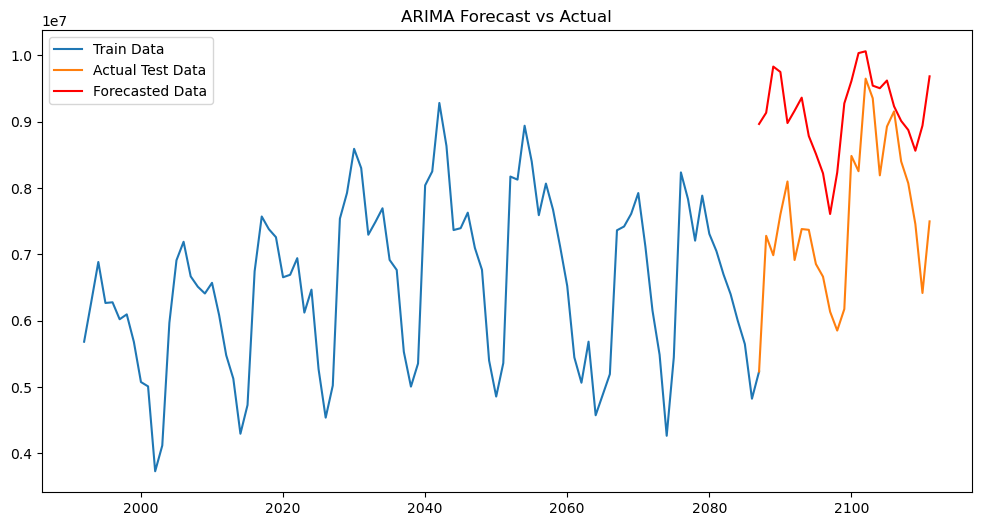

MSE: 3389183098891.503, MAE: 1604225.6009873105, RMSE: 1840973.4106964997


In [40]:
# Make forecast
forecast = model_fit.forecast(steps=len(test_data))

# Visual comparison
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['VALUE'], label='Train Data')
plt.plot(test_data.index, test_data['VALUE'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='Forecasted Data', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

# Calculate performance metrics
mse = mean_squared_error(test_data['VALUE'], forecast)
mae = mean_absolute_error(test_data['VALUE'], forecast)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

In [41]:
# Canadian_data['forecast']=model_fit.predict(start=0,end=120,dynamic=True)
# Canadian_data[['VALUE','forecast']].plot(figsize=(40,8))

In [42]:
Canadian_data.shape

(120, 4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52606D+01    |proj g|=  1.17781D+00


/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  1.47843D+01    |proj g|=  1.14529D-01

At iterate   10    f=  1.46982D+01    |proj g|=  5.98746D-02

At iterate   15    f=  1.46934D+01    |proj g|=  4.73249D-02

At iterate   20    f=  1.46860D+01    |proj g|=  7.71845D-02

At iterate   25    f=  1.46831D+01    |proj g|=  3.25414D-02

At iterate   30    f=  1.46817D+01    |proj g|=  6.59764D-03

At iterate   35    f=  1.46815D+01    |proj g|=  3.48018D-03

At iterate   40    f=  1.46814D+01    |proj g|=  1.57480D-03

At iterate   45    f=  1.46814D+01    |proj g|=  2.14912D-04

At iterate   50    f=  1.46814D+01    |proj g|=  2.65379D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: >

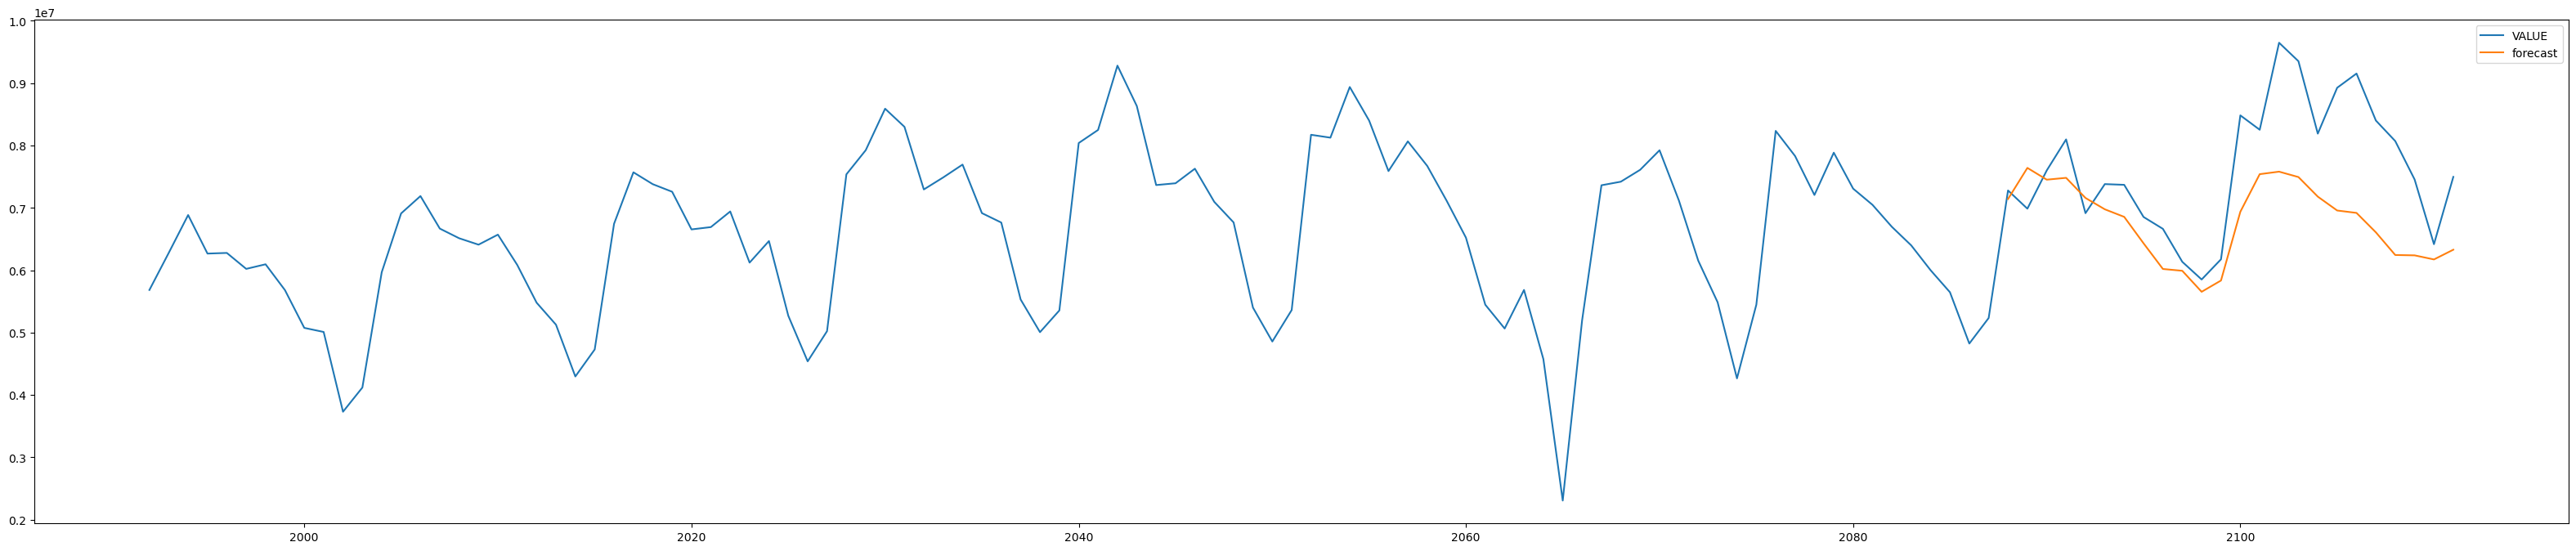

In [43]:
import statsmodels.api as sm
# model=sm.tsa.statespace.SARIMAX(Canadian_data['VALUE'],order=(12, 2, 1),seasonal_order=(12,2,1,12))
model=sm.tsa.statespace.SARIMAX(Canadian_data['VALUE'],order=(12, 2, 1))

results=model.fit()
Canadian_data['forecast']=results.predict(start=96,end=120,dynamic=True)
Canadian_data[['VALUE','forecast']].plot(figsize=(40,8))

In [44]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALUE   No. Observations:                  120
Model:              SARIMAX(12, 2, 1)   Log Likelihood               -1761.771
Date:                Tue, 23 Apr 2024   AIC                           3551.542
Time:                        12:35:16   BIC                           3590.331
Sample:                             0   HQIC                          3567.291
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0397      0.095      0.416      0.677      -0.147       0.227
ar.L2         -0.2658      0.099     -2.680      0.007      -0.460      -0.071
ar.L3         -0.3151      0.112     -2.805      0.005      -0.535      -0.095
ar.L4         -0.2387      0.123     -1.943      0.052      -0.480       0.002
ar.L5         -0.2394      0.109     -2.196      0.028      -0.453      -0.026
ar.L6         -0.1683      0.102     -1.644      0.100      -0.369       0.032
ar.L7         -0.2764      0.143     -1.936      0.053      -0.556       0.003
ar.L8         -0.2960      0.158     -1.871      0.061      -0.606       0.014
ar.L9         -0.0629      0.096     -0.652      0.514      -0.252       0.126
ar.L10        -0.2293      0.089     -2.581      0.010      -0.403      -0.055
ar.L11        -0.1316      0.146     -0.900      0.368      -0.418       0.155
ar.L12         0.3242      0.077      4.215      0.000       0.173       0.475
ma.L1         -0.9794      0.055    -17.660      0.000      -1.088      -0.871
sigma2      5.762e+11   1.19e-13   4.82e+24      0.000    5.76e+11    5.76e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                92.03
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                            -0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.64e+39. Standard errors may be unstable.
"""

In [45]:
Canadian_data.tail(12)

,REF_DATE,VALUE,Sales_First_Difference,Seasonal_First_Difference,forecast
2100,2023-03-01,8483490.0,2308521.0,1204417.0,6.937832e+06
2101,2023-04-01,8252891.0,-230599.0,1265954.0,7.540620e+06
2102,2023-05-01,9648708.0,1395817.0,2048238.0,7.580872e+06
2103,2023-06-01,9352513.0,-296195.0,1254351.0,7.494157e+06
2104,2023-07-01,8190694.0,-1161819.0,1275903.0,7.180232e+06
2105,2023-08-01,8926326.0,735632.0,1545170.0,6.957854e+06
2106,2023-09-01,9154748.0,228422.0,1785168.0,6.919091e+06
2107,2023-10-01,8400811.0,-753937.0,1546867.0,6.607546e+06
2108,2023-11-01,8071438.0,-329373.0,1408133.0,6.243971e+06
2109,2023-12-01,7455783.0,-615655.0,1320735.0,6.238256e+06


<Axes: >

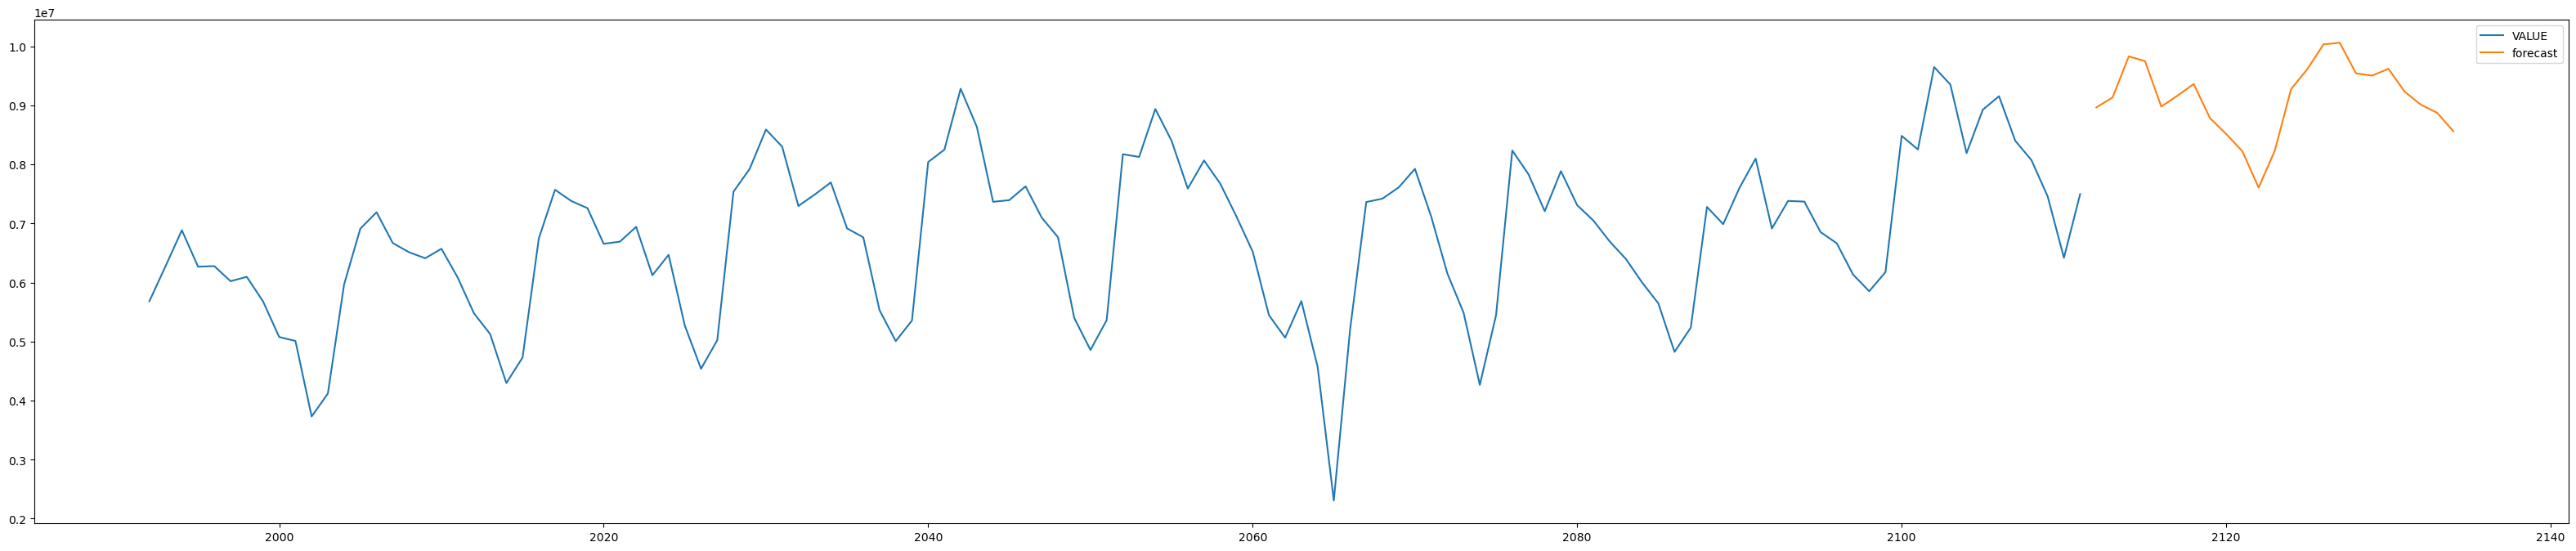

In [46]:
from pandas.tseries.offsets import DateOffset

# Convert the last date in the index to a Timestamp object
last_date = Canadian_data['REF_DATE'].index[-1]
#last_date = pd.to_datetime(last_date)

# Now you should be able to add DateOffset to the last date in the index
future_dates = [last_date + x for x in range(0, 24)]
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=Canadian_data.columns)

# Concatenate the original dataframe with the future dates dataframe
future_df = pd.concat([Canadian_data, future_datest_df])

# Assuming 'results' is your fitted model and it's already defined
future_df['forecast'] = results.predict(start=len(Canadian_data), end=len(Canadian_data)+24, dynamic=True)
future_df[['VALUE', 'forecast']].plot(figsize=(40, 8))


In [47]:
future_df[['VALUE', 'forecast']].tail(30)

,VALUE,forecast
2105,8926326.0,NaN
2106,9154748.0,NaN
2107,8400811.0,NaN
2108,8071438.0,NaN
2109,7455783.0,NaN
2110,6417326.0,NaN
2111,7497032.0,NaN
2112,NaN,8.965038e+06
2113,NaN,9.134413e+06
2114,NaN,9.830340e+06
